# Roller Coaster of Data:
## Analyzing roller coaster length on coasters around the world
#### By Woody Sims, Chief Data Scientist, United States Department of Roller Coaster Improvement (USDRCI)
<img src="https://media.giphy.com/media/MBy2eijcjNNr9jWHxF/giphy-downsized-large.gif">

# Goals:
## - Acquire data on roller coasters to find drivers of coaster length


## - Use those drivers to build a model to predict coaster length


## - Use that model to attempt to predict lengths of roller coasters

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import explore as e
import evaluate as ev
import wrangle as w
import model as m
from scipy import stats
from IPython.display import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')
pd.set_option('display.max_columns',None)

train, validate, test = w.wrangle_coasters()

# Executive Summary

### Key Findings
- Speed was the most obvious driver of coaster length
- Manufacturer also played a factor
- Clustering on these features did not yield significant results

### Recommmendations
- Collect more data on roller coasters
    - Launch coasters
- Update data to reflect more recent data
- Ride more roller coasters

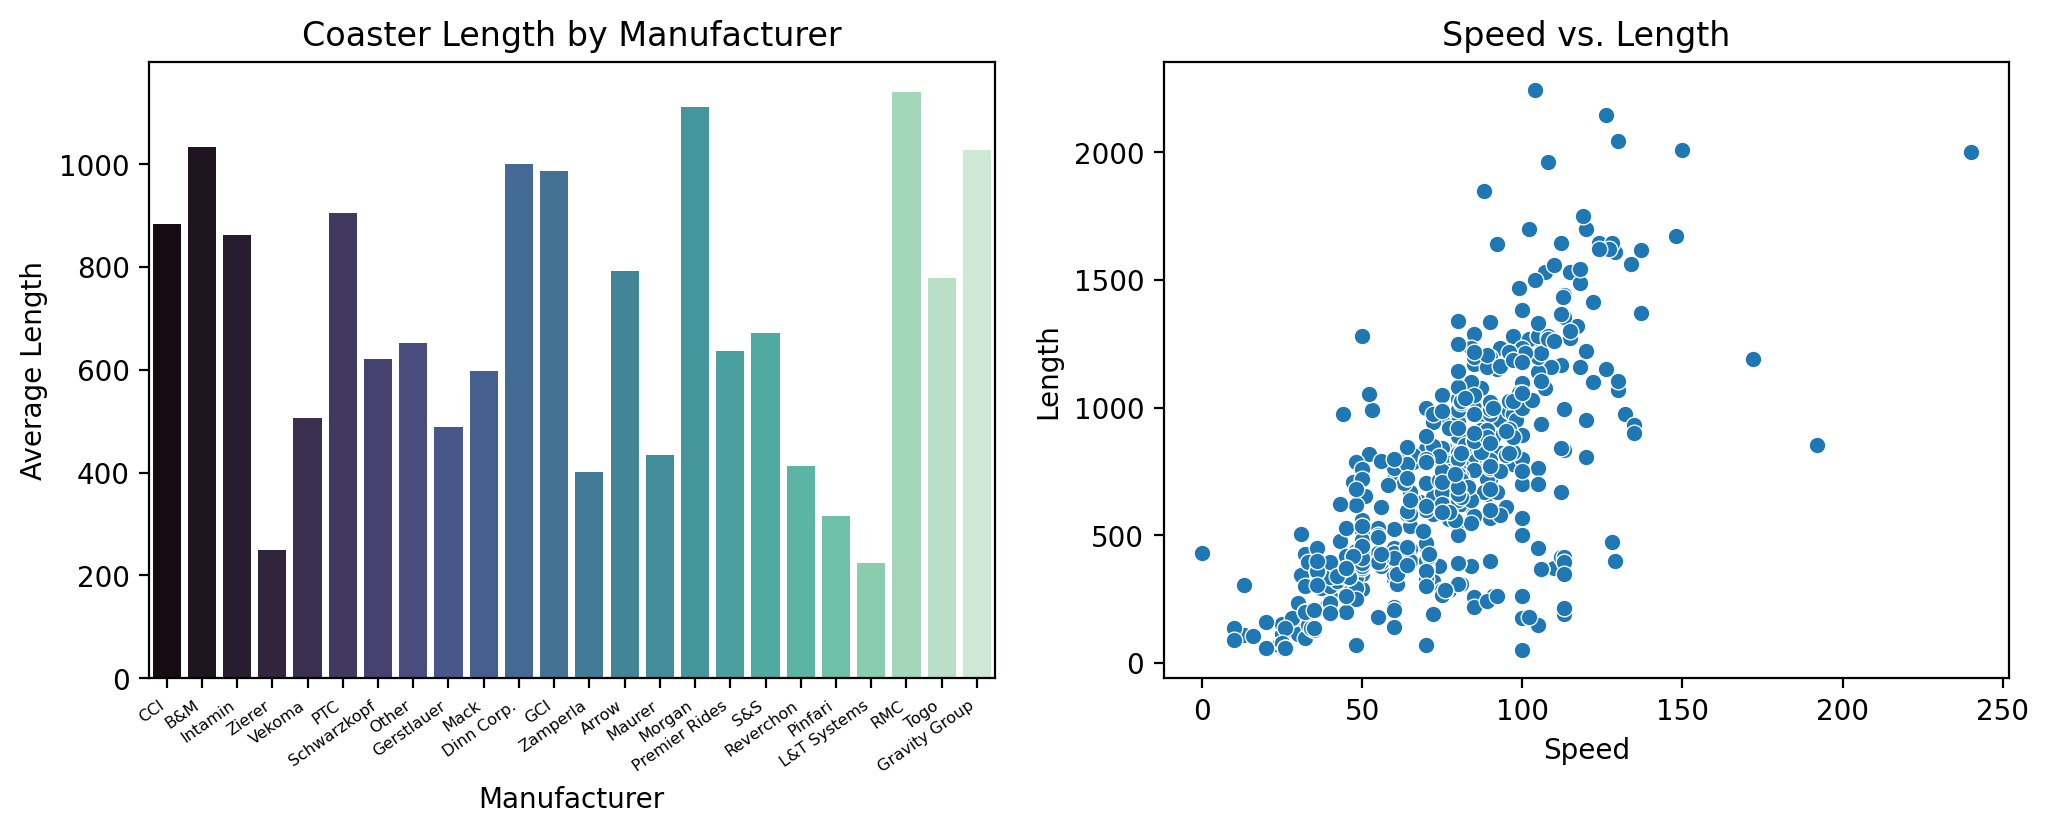

In [12]:
e.executive_summary(train)

# Data Dictionary
Variable Name | Data Type | Definition
--- | --- | ---
**name** | *string* |The name of the roller coaster
**steel_track** | boolean | Whether or not the track of the roller coaster is primarily steel
**seating_type** | category | The style of roller coaster (e.g. Sit Down, Stand Up, Inverted)
**speed** | *float* | the maximum speed of the roller coaster in km/h.
**height** | *float* | the maximum height of the roller coaster in meters.
**length** | *float* | the length of the roller coaster in meters (NOT in feet as Kaggle states)
**num_inversions** | *int* | The number of inversions on the roller coaster
**manufacturer** | *string* | The manufacturer of the roller coaster
**park** | *string* | The park the roller coaster is located at
**man_group** | *int* | value derrived from which manufacturers produce the longest roller coasters, grouped in groups of 5


# Acquire and Prepare

## Acquire
- Data was downloaded from [Kaggle](https://www.kaggle.com/datasets/thedevastator/roller-coaster-data-from-around-the-world)
- Before cleaning, data set had 2802 rows and 10 columns
- Each row represents a roller coaster
- Each column represents an observation about the roller coaster

## Prepare
- Removed any coasters that are rumored, under construction, or closed, temporarily or permanently
    - These accounted for the majority of the null values.
- Make corrections to outdated and incorrect data
- Engineer values
    - Update `material_type` to `steel_track` by changing values based on manufacturer of Hybrid coasters.
        - Arrow and RMC roller coasters have wooden supports and steel track
        - GCI and Gravity Group roller coasters have steel support with wooden track
    - Collapsed any manufacturers with 7 or fewer coasters to 'Other'
    - Based on training data `length`, grouped manufacturers into `man_groups`
- Data was then split into train, validate, and test datasets (roughly 55/25/15)
- After cleaning, data has 1187 rows and 11 columns



In [ ]:
train, validate, test = w.wrangle_coasters()

### A look at the data

In [ ]:
pd.read_csv('data/prepped/roller_coasters.csv').head().T

,0,1,2,3,4
name,Goudurix,Dream catcher,Alucinakis,Anaconda,Azteka
material_type,Steel,Steel,Steel,Wooden,Steel
seating_type,Sit Down,Suspended,Sit Down,Sit Down,Sit Down
speed,75.0,45.0,30.0,85.0,55.0
height,37.0,25.0,8.0,35.0,17.0
length,950.0,600.0,250.0,1200.0,500.0
num_inversions,7.0,0.0,0.0,0.0,0.0
manufacturer,Vekoma,Vekoma,Zamperla,William J. Cobb,Soquet
park,Parc Asterix,Bobbejaanland,Terra Mítica,Walygator Parc,Le Pal
status,status.operating,status.operating,status.operating,status.operating,status.operating


# Explore

## Question 1:
### Do steel roller coasters vary significantly in length from wooden ones?

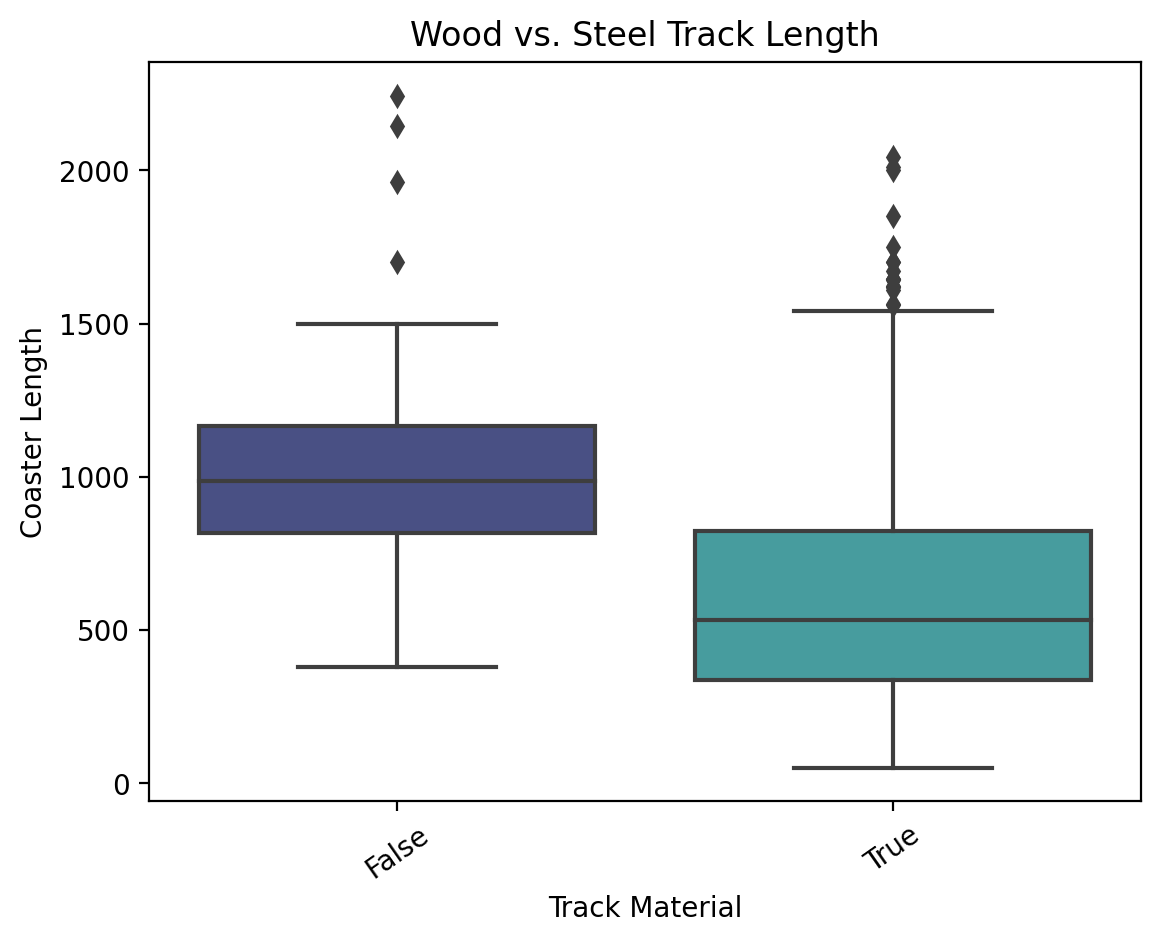

In [ ]:
e.wood_vs_steel(train)

### Is there a positive relationship between material type and length?
#### $H_0$: $\mu_{steel} = \mu_{wood}$
#### $H_a$: $\mu_{steel} \neq \mu_{wood}$

### Assumptions:
1. sets are independent ✅
2. sets are normally distributed ✅
3. Equal Variance❓

In [ ]:
e.wood_steel_levene(train)

## t = 3.7104805449349656 

 ## p = 0.0545003130170775 

## Because t > 0 and $\alpha$ < p, we failed to   reject $H_0$

### Because variances are not equal, we will use the `equal_variance`

In [ ]:
e.wood_steel_ttest(train)

## t = 8.23414260312759 

 ## p = 1.054675738327497e-12 

## Because t > 0 and $\alpha$ > p, we   reject $H_0$

#### From this, we can conclude that coaster track type is a likely a significant indicator of coaster length

### Question 2: Is there a relationship between coaster manufacturer and length?

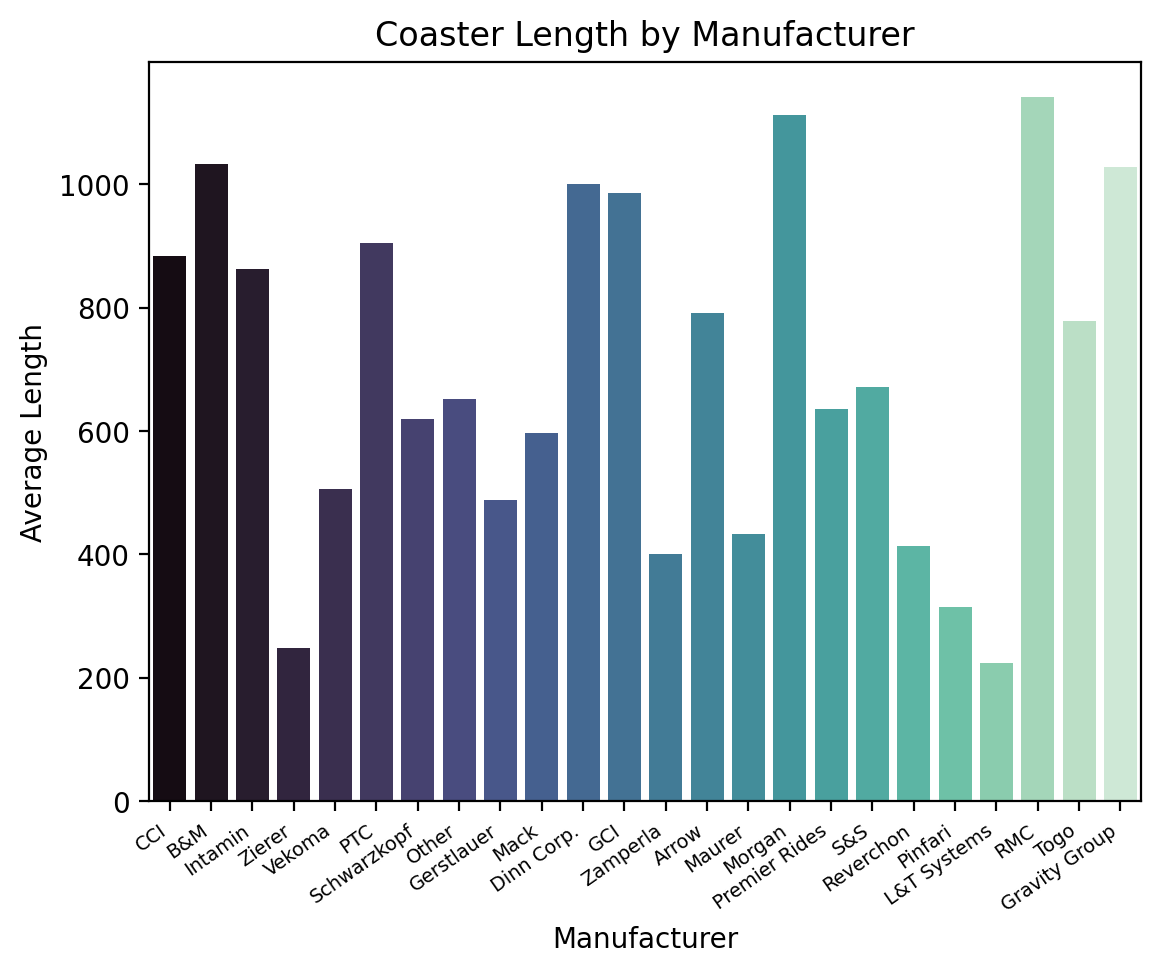

In [ ]:
e.manufacturers_v_length(train)

#### Many manufactuerers has a significant variety of coaster shapes and sizes. To simplify this, I created the man_group feature ranking the manufcaturers by their max length in the `train` dataset.

## Question: Is there a linear relationship between speed and length?

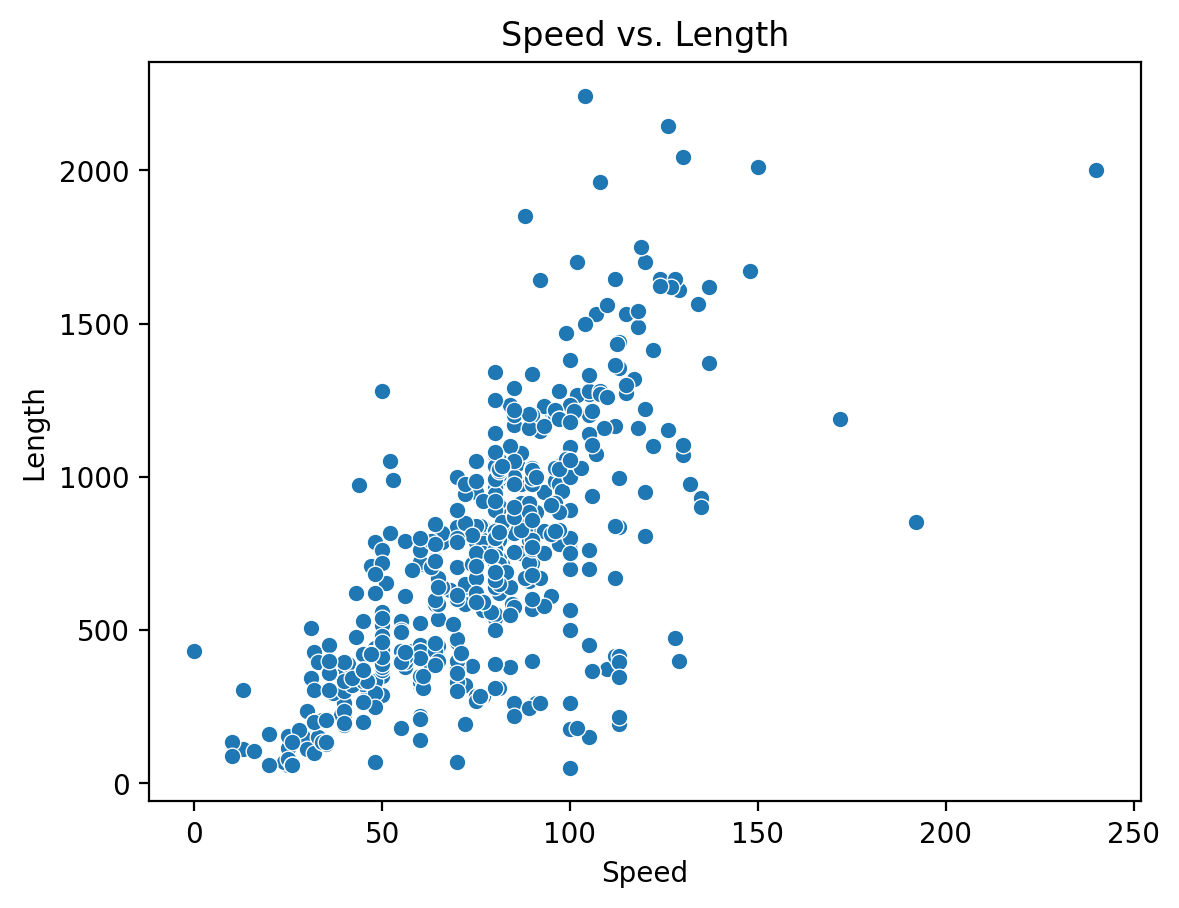

In [ ]:
e.speed_length(train)

### Hypotheses:
$H_{0}$: There is no strong linear correlation between speed and length

$H_{a}$: There is a linear correlation between speed and length

### Assumptions:
- Features are not ordinal ✅
- Features are normally distributed

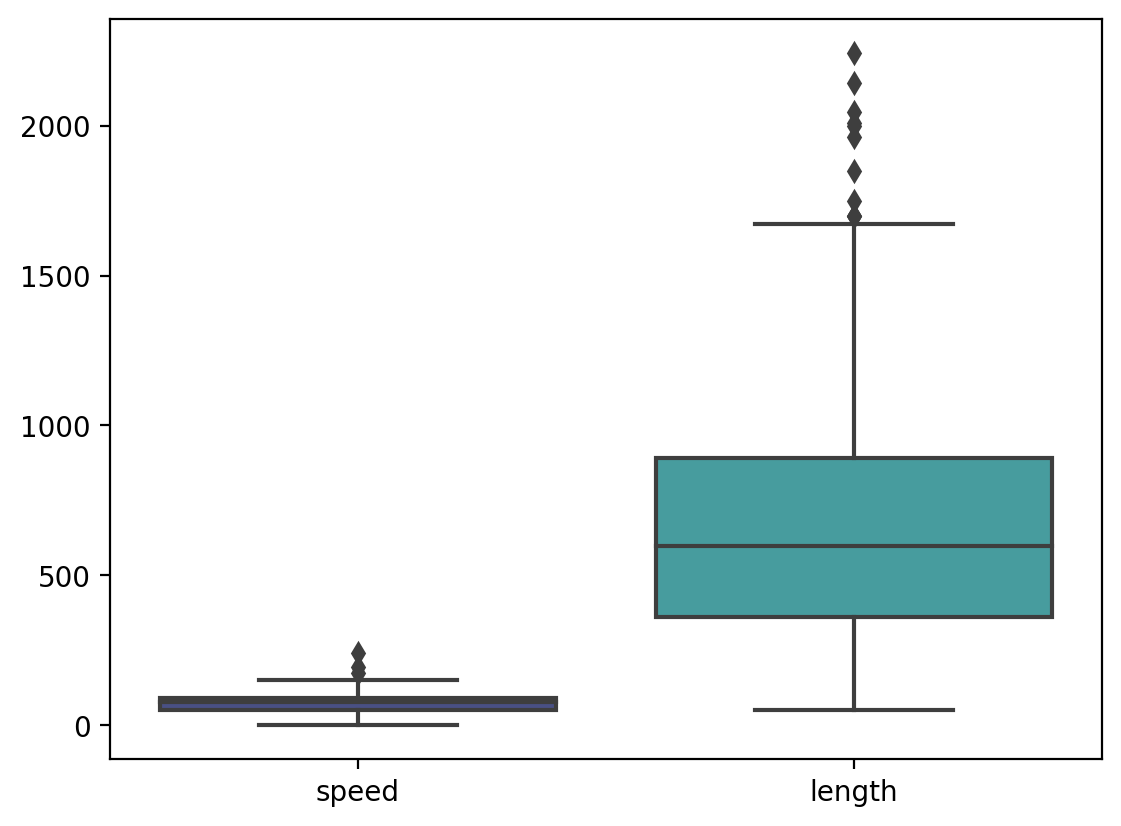

In [ ]:
e.speed_len_boxplot(train)

#### Because the values are not normally distributed, we will use the spearmanr test.

In [ ]:
e.speed_len_spearmanr(train)

## p = 9.192757381035074e-105
## r = 0.7148187774306639

## Because $\alpha$ > p,we  reject $H_0$

With a correlation coefficient of 0.69, we can assume a positive correlation between speed and length, and as such is a good potential candidate for a driver of coaster length

## Question 4: Could clustering on `speed` and `man_group` improve model performance?

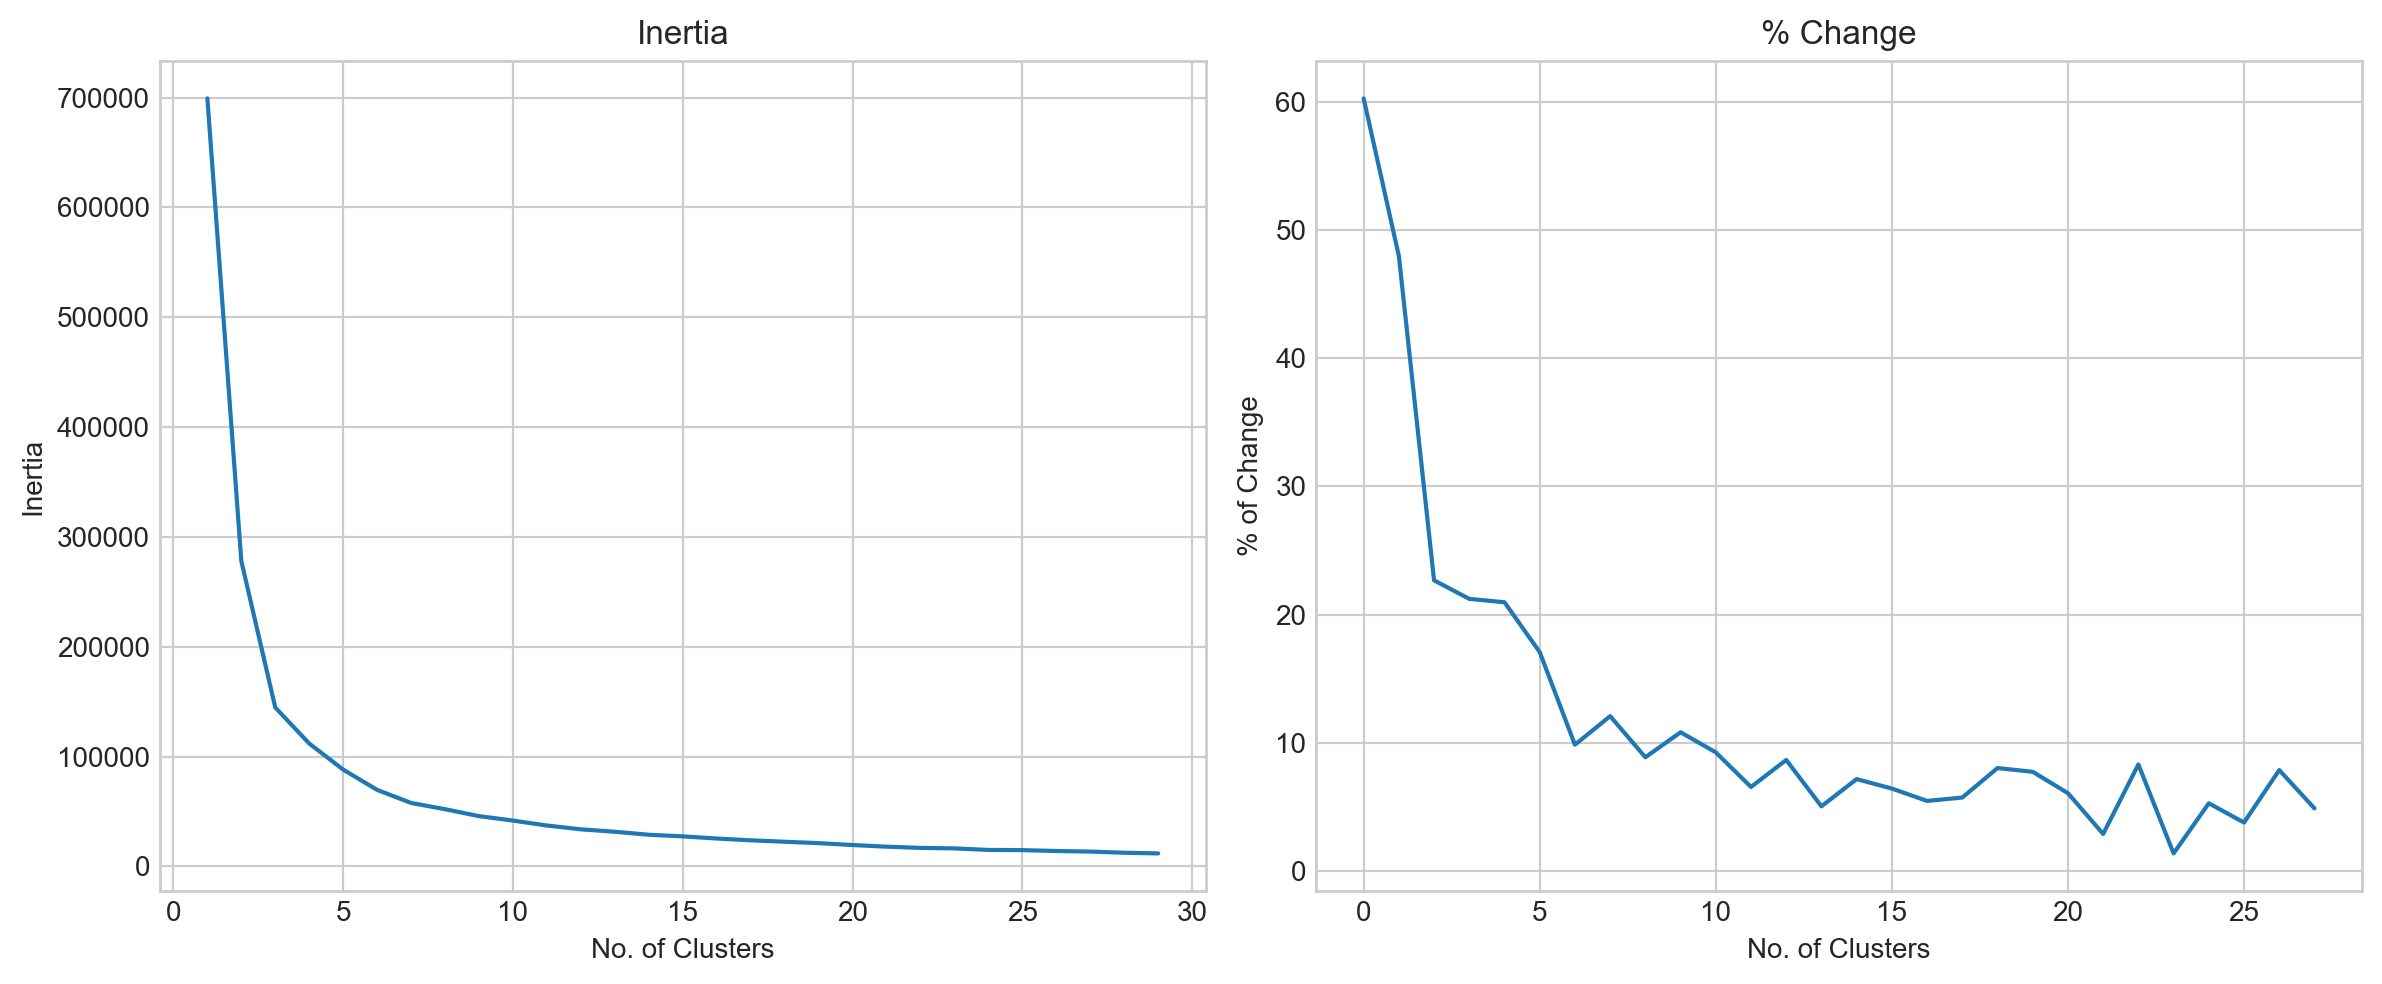

In [ ]:
e.generate_elbow(train[['speed','height','num_inversions']])

#### Based on the elbow graph and the percent change, we will cluster with k=6

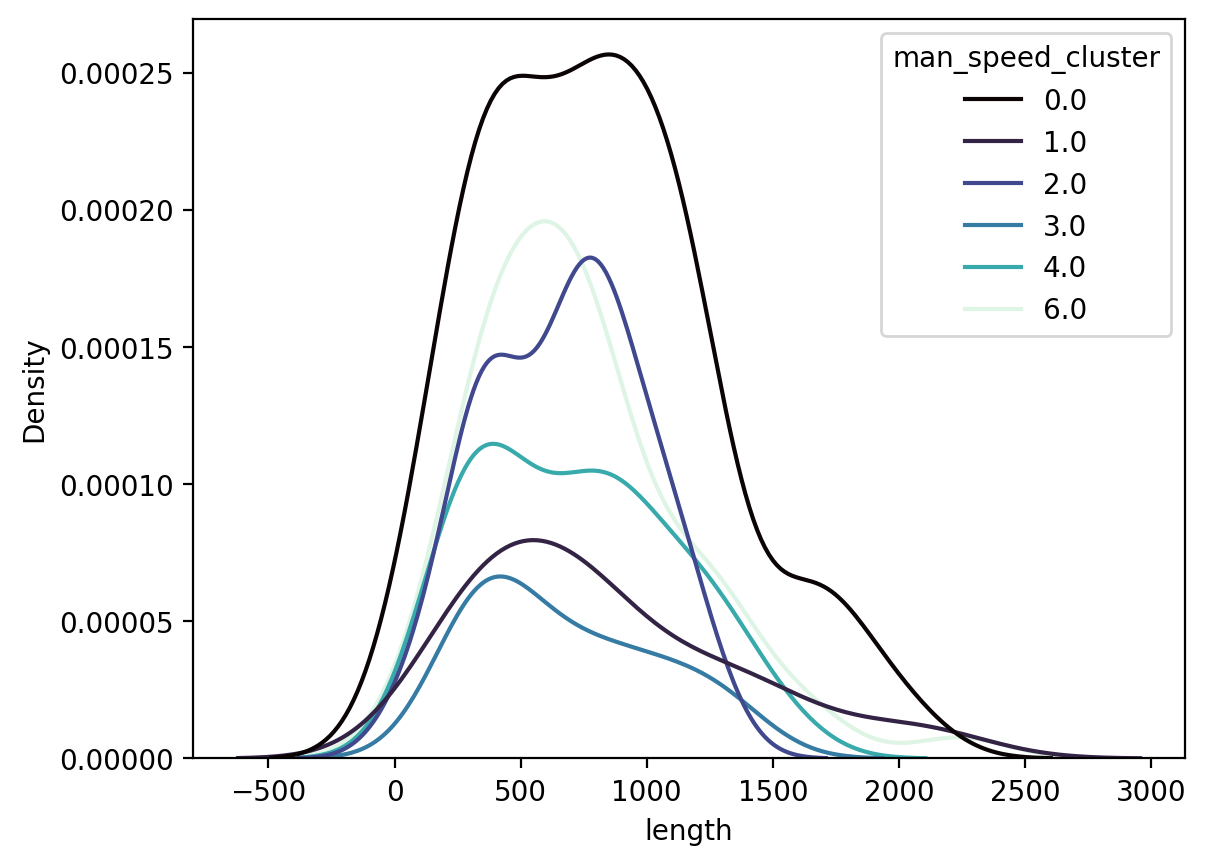

In [17]:
e.man_speed_kde(train)


#### Because clustering does not appear to distribute the means in any substantial way, I have decided against clustering moving forward.

## Takeaways:
- The most apparent drivers of coaster length are speed and manufacturer (which, for simplicity, are grouped).
- Track material also shows promise as a driver
- Clustering does not show much promise in improving model performance

# Modeling

## Baseline

In [ ]:
md,baseline = m.select_baseline(train.length)
md

|                 |         SSE |    MSE |    RMSE |
|:----------------|------------:|-------:|--------:|
| Mean Baseline   | 1.04585e+08 | 157745 | 397.172 |
| Median Baseline | 1.07079e+08 | 161506 | 401.878 |
### Because mean outperformed median on all metrics,we will use mean as our baseline

## Took 2 approaches to modeling:
### 1. Used a single model on all roller coasters
### 2. Broke data set into wooden and steel roller coasters, running a separate model on each

### Approach 1: Use a single model across all roller coasters

In [ ]:
m.try_models_train_validate(train, validate)

,Train,Validate
Linear Regression,264.933973,320.202225
Squared Regression,249.172382,295.400013
Cubed Regression,231.309010,300.265153
LASSO+LARS,264.933973,320.202225
LASSO+LARS^2,249.172382,295.400013
LASSO+LARS^3,231.309010,300.265153
GLM,264.933973,320.202225
GLM^2,249.172382,295.400013
GLM^3,231.309010,300.265153
Baseline,397.171592,421.870275


### Approach 2: Break data set into wooden and steel roller coasters and use a separate model on each

In [ ]:
m.wood_steel_permutations(train,validate)

,Train,Validate
LinearRegression+LinearRegression^2,249.172382,295.400013
LinearRegression+LassoLars^2,249.172382,295.400013
LinearRegression+GLM^2,249.172382,295.400013
LassoLars+LinearRegression^2,249.172382,295.400013
LassoLars+LassoLars^2,249.172382,295.400013
LassoLars+GLM^2,249.172382,295.400013
GLM+LinearRegression^2,249.172382,295.400013
GLM+LassoLars^2,249.172382,295.400013
GLM+GLM^2,249.172382,295.400013
LinearRegression+LinearRegression^3,231.309010,300.265153


#### Because separating by track type did not affect model performance, we will use a simple Linear Regression model, as it performed the best and is less processing-intensive

In [ ]:
m.run_test(train,test)

,Test
LinearRegression,257.476066
Baseline,386.720765


# Conclusion
## Exploration
- The most apparent drivers of coaster length are speed and manufacturer (which, for simplicity, are grouped).
- Track material also shows promise as a driver
- Clustering does not show much promise in improving model performance
## Modeling
- The best performing model was a simple Linear Regression
- Final model performed 33% better than the baseline

# Recommendations:
- Collect more observations on coasters
- Indicating whether a coaster is launched or lift-hill powered would improve speed as a metric
- Update data set to include more current coasters.
- Longer does not equal better

# THANK YOU

When I signed up for this, I never expected to get to meet so many cool, wonderful, and kind people. The past 4.5 months has been such a joy, and I hope y'all like me too cuz you're stuck with me 🥳 Mirzakhani Forever!